In [1]:
import h5py, sys, os
import numpy as np
from scipy.special import j1
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from pyhank import HankelTransform
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/N_175/512/


In [2]:
def amplitudes(var, rs, tstart, tend, z):
    tstart_idx = get_index(tstart, times)
    tend_idx = get_index(tend, times)
    
    waves = var[tstart_idx:1+tend_idx, get_index(z, gzf), :]
    
    H = HankelTransform(order=0, radial_grid = rs)

    wavesH = np.zeros_like(waves)

    for i in range(tend_idx-tstart_idx+1):
        wavesH[i] = H.qdht(waves[i])

    return np.fft.rfft(wavesH, axis=0)

Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Az keys: <KeysViewHDF5 ['b_az', 'bb_sfluc', 'p_az', 'th_az', 'u_az', 'ub_sfluc', 'uth_sfluc', 'uu_sfluc', 'uv_sfluc', 'uw_sfluc', 'v_az', 'vv_sfluc', 'vw_sfluc', 'w_az', 'wb_sfluc', 'ww_sfluc']>
Plume penetration occured at t=2.4639


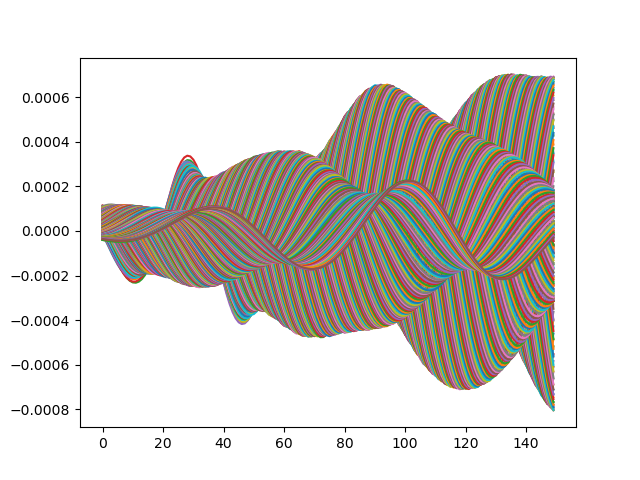

(180, 513, 256)
(180, 513, 256)
(150, 256)


In [3]:
#Load simulation data
_, times = load_data('th1_xz')
var1, var2 = load_az_data('w_az', 'b_az')
NSAMP = len(times)

times, t0_idx = calibrate_time(save_dir, times)

var2 = np.gradient(var2, gzf, axis=1)
var2 = np.gradient(var2, times, axis=0)

tstart_idx = get_index(5, times)
tend_idx = get_index(25, times)
zplot = 0.4

#waves = var2[tstart_idx:tend_idx+1, get_index(zplot, gzf), :]
waves = var1[tstart_idx:tend_idx+1, get_index(zplot, gzf), :]

plt.figure()
plt.plot(waves)
plt.show()

print(var1.shape)
print(var2.shape)
print(waves.shape)


In [4]:
print(md)

{'LX': 0.6, 'LY': 0.6, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 30.0, 'VERSION': 3.9, 'NU_START_TIME': 10.0, 'SAVE_STATS_DT_FINE': 0.1, 'FINE_RES_TIME': 5.0, 'TIME_LIMIT': 20.0, 'r0': 0.005, 'alpha_e': 0.1, 'b0': 0.2, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.1, 'N2': 3.0625, 'H': 0.2, 'b_factor': 0.4, 'Nb': 256.0, 'Nphi': 256.0, 'F_TYPE': 3.0, 'Nx': 512, 'Ny': 512, 'Nz': 513, 'Nth': 2}


In [5]:
dr = md['LX']/md['Nx']
nbins = int(md['Nx']/2)
r_bins = np.array([r*dr for r in range(0, nbins+1)])
r_points = np.array([0.5*(r_bins[i]+r_bins[i+1]) for i in range(nbins)])

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 180
Dimensional times:  [-2.46394815 -2.21394815 -1.96394815 -1.71394815 -1.46394815 -1.21394815
 -0.96394815 -0.71394815 -0.46394815 -0.21394815  0.          0.25
  0.5         0.75        1.          1.25        1.5         1.75
  2.          2.25        2.5         2.75        3.          3.25
  3.5         3.75        4.          4.25        4.5         4.75
  5.          5.1         5.2         5.3         5.4         5.5
  5.6         5.7         5.8         5.9         6.          6.1
  6.2         6.3         6.4         6.5         6.6         6.7
  6.8         6.9         7.          7.1         7.2         7.3
  7.4         7.5         7.6         7.7         7.8         7.9
  8.          8.1         8.2         8.3         8.4         8.5
  8.6         8.7         8.8         8.9         9.          9.1
  9.2         9.3         9.4         9.5         9.6         9.7
  9.8         9.9        10.         10.1        10.2        10.3
 10.4        10.5      

(76, 256)


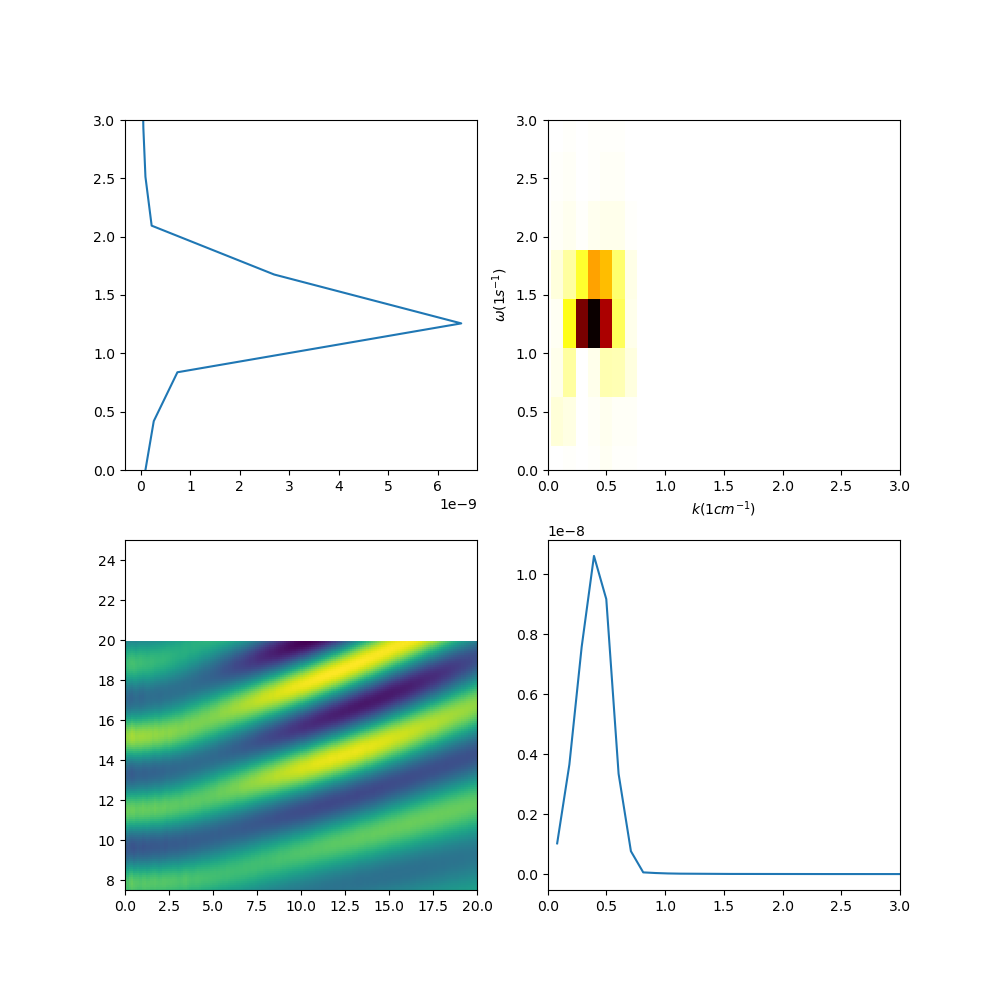

In [6]:
H = HankelTransform(order=0, radial_grid = r_points)

wavesH = np.zeros_like(waves)

for i in range(tend_idx-tstart_idx+1):
    wavesH[i] = H.qdht(waves[i])

amplitudes_nm = np.fft.rfft(wavesH, axis=0)

wavenumber_n = H.kr
freq_m = np.fft.rfftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']

print(amplitudes_nm.shape)
#print(wavenumber_n)
#print(freq_m)

power = np.power(np.abs(amplitudes_nm), 2)

X, Y = np.meshgrid(wavenumber_n/100, freq_m)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,1].pcolormesh(X, Y, power, cmap='hot_r')
ax[0,1].set_xlabel(r"$k (1 cm^{-1})$")
ax[0,1].set_ylabel(r"$\omega (1 s^{-1})$")
ax[0,1].set_xlim(0, 3)
ax[0,1].set_ylim(0, 3)

times_trunc = times[tstart_idx:tend_idx+1]
X, Y = np.meshgrid(r_points * 100, times_trunc)
ax[1,0].pcolormesh(X, Y, waves)
ax[1,0].set_xlim(0, 20)
ax[1,0].set_ylim(7.5, 25)

ax[0,0].plot(np.mean(power, axis=1), freq_m)
ax[0,0].set_ylim(0, 3)

ax[1,1].plot(wavenumber_n/100, np.mean(power, axis=0))
ax[1,1].set_xlim(0, 3)
plt.show()

In [7]:
##### Calculate vertical energy flux F_wave #####
R = np.max(r_points) # m
N = np.sqrt(md['N2']) # s^-1
rho_0 = 997 #kg per m^3

print(freq_m)
F_wave = 0
theta_m = np.arccos(freq_m/N)
for i in range(len(freq_m)):
    for j in range(len(wavenumber_n)):
        if 0 < freq_m[i] <= N:
            #k_z = np.sqrt(np.power(wavenumber_n[j],2)*(N*N/(freq_m[i]*freq_m[i])-1))
            F_wave += np.cos(theta_m[i]) * np.sin(2*theta_m[i]) * np.power(j1(wavenumber_n[j]*R),2) * \
                    np.power(np.abs(-amplitudes_nm[i,j]/(1j*freq_m[i])),2)/wavenumber_n[j]
                    #np.power(np.abs(-amplitudes_nm[i,j]/(k_z*N*N*freq_m[i])),2)/wavenumber_n[j]
        if np.isnan(F_wave):
            print(theta_m[i], wavenumber_n[j], amplitudes_nm[i,j])
            print(freq_m[i]/N)
            break
    if np.isnan(F_wave):
        break
        
        
F_wave *= 0.25*np.pi*np.power(R,2) * np.power(N,3)*rho_0
F_wave /= 1e-7
print(F_wave) # in erg s^-1

[ 0.          0.41887902  0.83775804  1.25663706  1.67551608  2.0943951
  2.51327412  2.93215314  3.35103216  3.76991118  4.1887902   4.60766923
  5.02654825  5.44542727  5.86430629  6.28318531  6.70206433  7.12094335
  7.53982237  7.95870139  8.37758041  8.79645943  9.21533845  9.63421747
 10.05309649 10.47197551 10.89085453 11.30973355 11.72861257 12.14749159
 12.56637061 12.98524963 13.40412866 13.82300768 14.2418867  14.66076572
 15.07964474 15.49852376 15.91740278 16.3362818  16.75516082 17.17403984
 17.59291886 18.01179788 18.4306769  18.84955592 19.26843494 19.68731396
 20.10619298 20.525072   20.94395102 21.36283004 21.78170906 22.20058809
 22.61946711 23.03834613 23.45722515 23.87610417 24.29498319 24.71386221
 25.13274123 25.55162025 25.97049927 26.38937829 26.80825731 27.22713633
 27.64601535 28.06489437 28.48377339 28.90265241 29.32153143 29.74041045
 30.15928947 30.57816849 30.99704752 31.41592654]
10.976471088975996


/tmp/ipykernel_212982/1633408825.py:8: RuntimeWarning: invalid value encountered in arccos
  theta_m = np.arccos(freq_m/N)


In [8]:
##### Calculate characteristic frequency #####
omega_c = 0
norm = 0

A_xim2 = np.mean(power, axis=1)

for i in range(len(freq_m)):
    norm += A_xim2[i]
    omega_c += freq_m[i]*A_xim2[i]

omega_c /= norm
print(omega_c)
print(omega_c/N)

1.4622117399607617
0.8355495656918638


In [9]:
##### Calculate characteristic radial wavenumber #####
norm = 0
k_c = 0

A_xim2 = np.mean(power, axis=0)

for i in range(len(wavenumber_n)):
    norm += A_xim2[i]
    k_c += wavenumber_n[i]*A_xim2[i]

k_c /= norm
print(k_c/100)

0.3993322570844296


In [10]:
print(H.kr*R)
print(H.alpha)

[  2.40482556   5.52007811   8.65372791  11.79153444  14.93091771
  18.07106397  21.21163663  24.35247153  27.49347913  30.63460647
  33.77582021  36.91709835  40.05842576  43.19979171  46.34118837
  49.4826099   52.62405184  55.76551076  58.90698393  62.04846919
  65.1899648   68.33146933  71.4729816   74.61450064  77.75602563
  80.89755587  84.03909078  87.18062984  90.32217264  93.46371878
  96.60526795  99.74681986 102.88837425 106.02993092 109.17148965
 112.31305028 115.45461265 118.59617663 121.73774209 124.87930891
 128.02087701 131.16244628 134.30401664 137.44558802 140.58716035
 143.72873357 146.87030763 150.01188246 153.15345802 156.29503427
 159.43661116 162.57818867 165.71976675 168.86134537 172.0029245
 175.14450412 178.2860842  181.42766471 184.56924564 187.71082696
 190.85240865 193.9939907  197.13557309 200.27715579 203.41873881
 206.56032212 209.7019057  212.84348956 215.98507367 219.12665803
 222.26824262 225.40982743 228.55141247 231.6929977  234.83458314
 237.976168